# Descrpción general

EXPLICACION UNO: La base de datos empleada para este análisis se obtuvo del siguiente  [link](https://www.kaggle.com/datasets/wasiqaliyasir/diabates-dataset/data). Se trata de un conjunto de datos que contiene 200 observaciones y 8 indicadores:

**PatientID (entero):** identificador único del registro.

**Age (entero, años):** edad del paciente.

**Gender (categórica, Male/Female):** género reportado.

**BMI (numérica, kg/m²):** índice de masa corporal; valores mayores suelen indicar sobrepeso/obesidad.

**BloodPressure (numérica, mmHg):** presión arterial (en este dataset suele referirse a la medición diastólica).

**Insulin (numérica, μU/mL):** nivel de insulina en sangre.

**Glucose (numérica, mg/dL):** concentración de glucosa en plasma.

**DiabetesPedigreeFunction (numérica, índice):** indicador derivado que resume carga familiar/riesgo genético de diabetes (valores altos = mayor carga familiar).

**Outcome (binaria: 1/0):** variable objetivo; 1 = tiene diabetes, 0 = no tiene.

Estos datos fueron proporcionados por Wasiq Ali, en la plataforma [Kaggle](https://www.kaggle.com/datasets).

En este modelo, buscaremos predecir si se tiene diabetes o no (nos referimos a el como Outcome en todo el trabajo), a partir de la información dada. 

Comenzamos leyendo  el archivo nombrado "Diabetes.csv" y se imprimen las primeras 10 filas para confirmar su correcta lectura.

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

df = pd.read_csv("Diabetes.csv")
df.head()

,PatientID,Age,Gender,BMI,BloodPressure,Insulin,Glucose,DiabetesPedigreeFunction,Outcome
0,1,52,Male,30.239636,149,113,115,0.312886,1
1,2,53,Female,30.932781,71,39,104,0.389526,0
2,3,21,Male,45.092714,161,67,151,1.205869,0
3,4,39,Male,47.795530,101,165,184,0.595201,1
4,5,22,Female,20.718108,160,158,116,0.974248,1


Imprimimos las proporciones de nuestra columna objetivo, en este caso Outcome.
Se normaliza y cambiamos las etiquetas del índice de 0-1 a No Diabetes y Diabetes.
Nos sirve para verificar si hay algún desbalance y tomar una decisión para el método a usar en el split.

In [55]:
print("\nProporciones del outcome:")
df['Outcome'].value_counts(normalize=True).rename({0:'No Diabetes',1:'Diabetes'})


Proporciones del outcome:


Outcome
No Diabetes    0.525
Diabetes       0.475
Name: proportion, dtype: float64

Preparamos los features (X) y nuestro objetivo (Y) para entrenar la regresión.
Quitamos de los predictores, en nuestro caso Outcome porque es la variable que queremos predecir y quitamos PatientID, porque solo sirve como identificador, no aporta información útil al modelo.
Definimos nuestra variable objetivo y = df['Outcome']  como 0 = No Diabetes, 1 = Diabetes.
Convertimos todas las columnas categóricas de X a numéricas con one-hot encoding, en nuestro caso creamos el dummie Gender_Male para verificar con True o False el género de la observación.
Y por último mostramos en pantalla las nuevas dimensiones de  nuestra base de datos.

In [38]:
X = df.drop(columns=['Outcome', 'PatientID'])
y = df['Outcome']
X = pd.get_dummies(X, drop_first=True)
print("\nShape X, y:", X.shape, y.shape)
X.head()


Shape X, y: (200, 7) (200,)


,Age,BMI,BloodPressure,Insulin,Glucose,DiabetesPedigreeFunction,Gender_Male
0,52,30.239636,149,113,115,0.312886,True
1,53,30.932781,71,39,104,0.389526,False
2,21,45.092714,161,67,151,1.205869,True
3,39,47.795530,101,165,184,0.595201,True
4,22,20.718108,160,158,116,0.974248,False


EXPLICACION DOS: Dividimos el dataset en Train (80%) y Test (20%) conservando la proporción de clases (diabéticos/no diabéticos). 
Usamos stratify=y para evitar que por azar, el conjunto de prueba quede sesgado hacia una clase, esto mantiene la proporción de las clases.
Y mostramos una tabla el porcentaje de cada clase en Original/Train/Test verificando que no haya cambios muy bruscos entre estos.

In [40]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

def proporciones(nombre, serie):
    p = serie.value_counts(normalize=True).sort_index()
    return pd.Series({f"{nombre} - Clase 0": p.get(0, np.nan),
                      f"{nombre} - Clase 1": p.get(1, np.nan)})

resumen = pd.concat([
    proporciones("Original", y),
    proporciones("Train", y_train),
    proporciones("Test", y_test)
], axis=1)

display(resumen.T.style.format("{:.3f}"))


,Original - Clase 0,Original - Clase 1,Train - Clase 0,Train - Clase 1,Test - Clase 0,Test - Clase 1
0,0.525,0.475,nan,nan,nan,nan
1,nan,nan,0.525,0.475,nan,nan
2,nan,nan,nan,nan,0.525,0.475


EXPLICACION TRES: Ahora queremos estimar el desempeño fuera de muestra de la regresión logística para predecir el Outcome, decidimos usar k-fold con cross_validate + StratifiedKFold: dividimos el set de entrenamiento en 5 “folds” estratificados (mantienen la proporción de 0/1), entrenamos la regresión logística en 4 folds y la evaluamos en el fold restante, repitiendo el proceso 5 veces y usamos métricas que priorizan la detección de positivos (recall, F1), además de accuracy, precision y ROC-AUC.

Al ver las tablas podemos interpretarlas como:

Recall (media 0.767 ± 0.160), el modelo detecta aprox. 77% de los diabéticos reales. Es lo que priorizamos (menos falsos negativos).

Precision (0.697 ± 0.093), de los que marca como diabéticos, aprox. 70% realmente lo son (30% falsos positivos).

F1 (0.727 ± 0.120), equilibrio entre recall y precision: desempeño sólido para el dataset que es pequeño.

ROC-AUC (0.708 ± 0.085), discriminación aceptable.

Accuracy (0.731 ± 0.110), aciertos totales aprox 73%. Este puede verse afectada por el balance de clases.

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.linear_model import LogisticRegression

X_out = df.drop(columns=["Outcome", "PatientID"], errors="ignore")
X_out = pd.get_dummies(X_out, drop_first=True)   # por si hubiera categóricas (e.g., Gender)
y_out = df["Outcome"]

X_out_train, X_out_test, y_out_train, y_out_test = train_test_split(
    X_out, y_out, test_size=0.2, random_state=42, stratify=y_out
)

log_out = LogisticRegression(solver="lbfgs", max_iter=1000, class_weight="balanced")

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "accuracy":  "accuracy",
    "recall":    "recall",    
    "precision": "precision",
    "f1":        "f1",
    "roc_auc":   "roc_auc"
}

cv_res_out = cross_validate(
    log_out, X_out_train, y_out_train,
    cv=cv, scoring=scoring, return_train_score=False
)

tabla_cv_out = pd.DataFrame({
    "accuracy":  cv_res_out["test_accuracy"],
    "recall":    cv_res_out["test_recall"],
    "precision": cv_res_out["test_precision"],
    "f1":        cv_res_out["test_f1"],
    "roc_auc":   cv_res_out["test_roc_auc"],
})
display(tabla_cv_out.round(3))

resumen_cv_out = pd.DataFrame({
    "métrica":  tabla_cv_out.columns,
    "media":    tabla_cv_out.mean().values,
    "desv_std": tabla_cv_out.std(ddof=1).values
}).sort_values("métrica")

display(resumen_cv_out.style.format({"media":"{:.3f}", "desv_std":"{:.3f}"}))


,accuracy,recall,precision,f1,roc_auc
0,0.844,0.933,0.778,0.848,0.773
1,0.812,0.800,0.800,0.800,0.784
2,0.719,0.800,0.667,0.727,0.729
3,0.719,0.800,0.667,0.727,0.678
4,0.562,0.500,0.571,0.533,0.574


,métrica,media,desv_std
0,accuracy,0.731,0.110
3,f1,0.727,0.120
2,precision,0.697,0.093
1,recall,0.767,0.160
4,roc_auc,0.708,0.085


EXPLICACION CUATRO: Con todo el set de entrenamiento ajusté el modelo final y en el set de prueba calculé probabilidades.
El clasificador probabilístico permite mover el umbral de decisión, por lo que evalúe tres puntos:

Umbral 0.5: Exactitud 0.80, Recall 0.84, Especificidad 0.76. Detecta la mayoría de positivos sin disparar falsos positivos.

Umbral 0.3: Exactitud 0.65, Recall 0.84, Especificidad 0.48. Mantiene el recall, pero cae mucho la especificidad (muchos falsos positivos); no mejora frente a 0.5.

Umbral 0.7: Exactitud 0.63, Recall 0.32, Especificidad 0.91. Minimiza falsos positivos pero se escapan muchos positivos.

Con estos datos, me quedo con 0.5 como mejor equilibrio entre sensibilidad y especificidad. Si el objetivo fuera aún más conservador en no perder positivos, podría bajar un poco el umbral sabiendo que suben los falsos positivos; si en cambio, se quisiera minimizar falsos positivos, subiría el umbral aceptando menor recall.


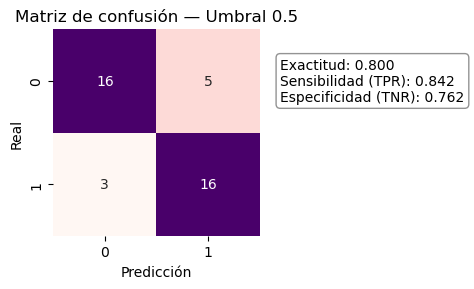

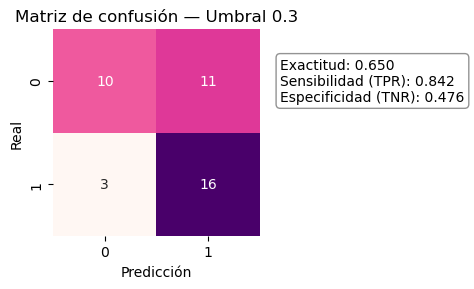

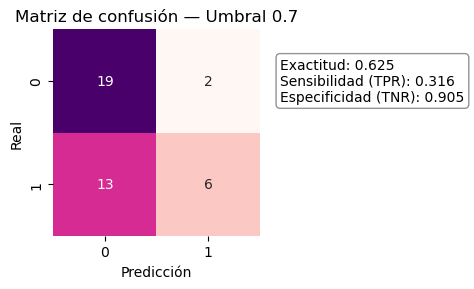

In [61]:
import seaborn as sns

def plot_confusion_matrix_square(cm, acc, sens, esp, title):
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="RdPu", cbar=False, square=True,
                xticklabels=[0,1], yticklabels=[0,1])

    plt.title(title)
    plt.xlabel("Predicción")
    plt.ylabel("Real")

    texto = (
        f"Exactitud: {acc:.3f}\n"
        f"Sensibilidad (TPR): {sens:.3f}\n"
        f"Especificidad (TNR): {esp:.3f}"
    )
    plt.text(
        2.2, 0.5, texto, fontsize=10, va='center',
        bbox=dict(boxstyle="round", facecolor="white", alpha=0.85, edgecolor="gray")
    )

    plt.tight_layout()
    plt.show()

umbrales = [0.5, 0.3, 0.7]
for u in umbrales:
    cm, acc, sens, esp = metricas_umbral(y_test, y_prob, u)
    plot_confusion_matrix_square(cm, acc, sens, esp, f"Matriz de confusión — Umbral {u}")



EXPLICACION CINCO: 
Se hace la gráfica de curva ROC, dando 0.752, es decir si tomo al azar un paciente con diabetes y uno sin, el modelo asigna mayor probabilidad al diabético en aprox. 75% de las veces. Es una discriminación aceptable.

Cómo se ve en la gráfica la curva pega un salto vertical alrededor de FPR 0.2 llega a TPR en aprox. 0.85. Eso indica que podemos lograr alta sensibilidad con pocos falsos positivos antes de que los rendimientos disminuyan.
Los tramos escalonados se deben a que el set de prueba es chico.

Con este conjunto, el modelo separa razonablemente bien a diabéticos de no diabéticos (AUC aprox. 0.75) y permite trabajar con un umbral cerca de 0.5 para mantener alta sensibilidad sin inflar en exceso los falsos positivos.


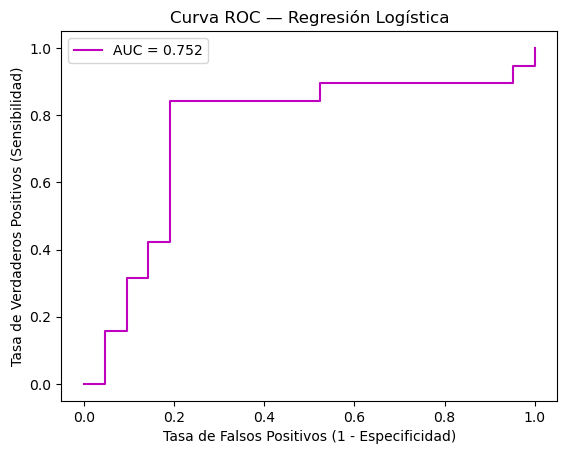

AUC: 0.7519


In [45]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color="m", label=f"AUC = {auc:.3f}")
plt.xlabel('Tasa de Falsos Positivos (1 - Especificidad)')
plt.ylabel('Tasa de Verdaderos Positivos (Sensibilidad)')
plt.title('Curva ROC — Regresión Logística')
plt.legend()
plt.show()

print("AUC:", round(auc, 4))


EXPLICACION SEIS: La tabla muestra qué variables se asocian más con tener diabetes y en qué dirección.

Cuando el Odds Ratio (OR) es mayor que 1, la variable se asocia con más probabilidad de diabetes; si es menor que 1, con menos probabilidad (efecto “protector”).

DiabetesPedigreeFunction — OR = 1.318 es el factor más influyente: sube aprox. 32% la probabilidad relativa por cada punto de DPF.

BMI — OR = 1.065, cada punto extra de IMC sube aprox. 6.5% la probabilidad relativa.

BloodPressure — OR = 1.024, cada unidad sube aprox. 2.4%.

Glucose — OR = 1.012, cada unidad sube aprox. 1.2%.

Age — OR = 1.009, cada año sube aprox. 0.9%.

Insulin — OR = 1.009, cada unidad sube aprox. 0.9%.

Gender_Male — OR = 0.440, ser hombre (vs. mujer, que es la categoría base) se asocia con aprox. 56% menos probabilidad relativa de diabetes, dado el mismo perfil clínico.

En el modelo el antecedente familiar (DPF) y el IMC son los impulsores positivos más claros; presión, glucosa, edad e insulina aportan incrementos más pequeños; y ser hombre aparece con efecto un tipo protector relativo frente a la mujer en esta muestra.

In [62]:
coef_df = pd.DataFrame({
    "Variable": X.columns,
    "Coeficiente": log_clf.coef_[0],
})
coef_df["Odds Ratio (exp)"] = np.exp(coef_df["Coeficiente"])
coef_df = coef_df.sort_values(by="Coeficiente", ascending=False).reset_index(drop=True)

display(coef_df)

print("\nInterpretación:")
print("- Un odds ratio > 1 indica un incremento en la odds de tener diabetes por unidad de la variable.")
print("- Un odds ratio < 1 indica un efecto 'protector' (disminuye odds de tener diabetes).")


,Variable,Coeficiente,Odds Ratio (exp)
0,DiabetesPedigreeFunction,0.276215,1.318132
1,BMI,0.062869,1.064888
2,BloodPressure,0.023372,1.023647
3,Glucose,0.011435,1.011501
4,Age,0.009385,1.009429
5,Insulin,0.008837,1.008876
6,Gender_Male,-0.822037,0.439535



Interpretación:
- Un odds ratio > 1 indica un incremento en la odds de tener diabetes por unidad de la variable.
- Un odds ratio < 1 indica un efecto 'protector' (disminuye odds de tener diabetes).
